# KPS 4 - PROJETO DE SOFTWARE PARA ANÁLISE DE TRELIÇAS PLANAS

In [103]:
from funcoesTermosol import geraSaida, importa, plota
import numpy as np
from math import sqrt 

In [104]:
# def gauss_seidel(A, b, tolerance, x):
def gauss_seidel(ite, tol, K, F):
    # ite = número máximo de iterações
    # tol = tolerância
    # K = matriz de rigidez após aplicação da condição de contorno
    # F = vetor de forças após aplicação da condição de contorno
    
    U = np.zeros(len(F))
    # U é a condição inicial dos deslocamentos
    
    n_iter = 0
  
    while(n_iter <= ite):
        n_iter += 1
     
        U_old  = U.copy()
        
        for i in range(K.shape[0]):
            U[i] = (F[i] - np.dot(K[i,:i], U[:i]) - np.dot(K[i,(i+1):], U_old[(i+1):])) / K[i, i]
            
        
        erro = max(abs((U - U_old)))/max(abs(U))   
        if  erro < tol:
            print ("A solução do sistema na iteração", n_iter, "é:", U)
            break
    
           
    return U, erro

A solução do sistema na iteração 23 é: [-9.52380952e-07  1.60714286e-06 -4.01785714e-06]
[[0.  0.  0.3]
 [0.  0.4 0.4]]


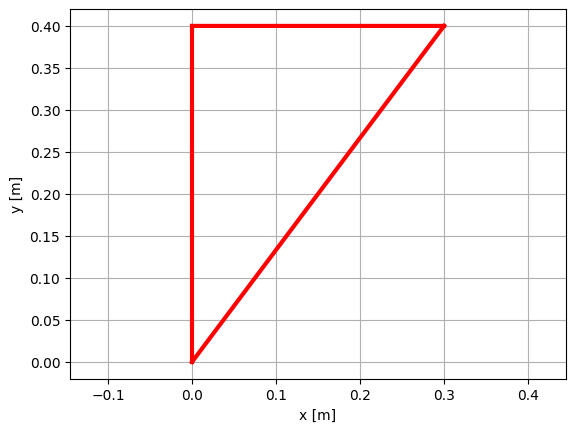

In [105]:
class Node:
    def __init__(self, x, y, gl):
        # Coordenadas em x e y do nó
        self.x = x
        self.y = y
        # Graus de liberdade do nó
        self.gl = gl

# Matriz para cálculo da matriz de rigidez Ke
matriz_um = np.array([[1, -1], [-1, 1]])

class Elemento:
    def __init__(self, no1, no2, E, A):
        # Módulo de eláticidade (Pa)
        self.E = E
        # Área da seção transversal (m²)
        self.A = A
        # Comprimento do elemento (m)
        self.l = sqrt((no1.x - no2.x)**2 + (no1.y - no2.y)**2)
        # Cosseno e seno calculados para o elemento
        self.cos = (no2.x - no1.x)/self.l
        self.sin = (no2.y - no1.y)/self.l
        # Matriz de transformação e sua transposta
        self.T = np.array([[self.cos, self.sin, 0, 0],
                          [0, 0, self.cos, self.sin]])
        self.T_transposta = np.transpose(self.T)
        # Matriz de rigidez do elemento
        self.ke = np.dot(np.dot(self.T_transposta * (self.E*self.A/self.l), matriz_um), self.T)
        # Graus de liberdade referentes aos nós do elemento
        self.gls = np.concatenate((no1.gl, no2.gl))
        # Deformação no elemento
        self.deformacao = 0
        # Tensão do elemento (Pa)
        self.tensao = 0
        # Força interna do elemento (N)
        self.finterna = 0

# Importa dados do arquivo de entrada
# numero de nos [nn]
# matriz dos nos [N]
# numero de membros [nm]
# matriz de incidencia [Inc]
# numero de cargas [nc]
# vetor carregamento [F]
# numero de restricoes [nr]
# vetor de restricoes [R]
[nn, N, nm, Inc, nc, F, nr, R] = importa('entrada.xls')

# Criar um objeto Node para cada nó
NODES = []
for n in range(nn):
    gdl = [((n+1)*2)-1, (n+1)*2]
    new_node = Node(N[0, n], N[1, n], gdl)
    NODES.append(new_node)

# Criar um objeto Elemento para cada membro
ELEMENTOS = []
for m in range(nm):
    new_element = Elemento(NODES[int(Inc[m, 0])-1], NODES[int(Inc[m, 1])-1], float(Inc[m, 2]), float(Inc[m, 3]))
    ELEMENTOS.append(new_element)

# Cria matriz de rigidez para superposição das matrizes de rigidez dos elementos
K = np.zeros((2*nn, 2*nn))

AUXS = [e.gls for e in ELEMENTOS]
for aux, elemento in zip(AUXS, ELEMENTOS):
    for i in range(len(aux)):
        for j in range(len(aux)):
            K[aux[i]-1, aux[j]-1] += elemento.ke[i, j]

# Aplicando condição de contorno (Aula 25 -> Slide 23)
# Removendo linhas e colunas que correspondem aos graus de liberdade das reações dos nós
# Documentação para o np.delete: https://note.nkmk.me/en/python-numpy-delete/#:~:text=Using%20the%20NumPy%20function%20np,from%20the%20NumPy%20array%20ndarray%20.&text=Specify%20the%20axis%20(dimension)%20and,a%20slice%20or%20a%20list.
R = R.astype(int).flatten()
K_CC = np.delete(np.delete(K, R, 0), R, 1)

# F é o vetor global de forças concentradas (Aula 25 -> Slide 22)
PG_CC = np.delete(F, R, 0)

# Calcular os deslocamentos nodais (Aula 25 -> Slide 24)
deslocamentos, erro = gauss_seidel(10000, 1e-10, K_CC, PG_CC)

# Calcular reações de apoio (Aula 25 -> Slide 25)
deslocamentos_expandido = np.zeros(len(F))
for i in range(len(deslocamentos_expandido)):
    if i not in R:
        deslocamentos_expandido[i] = deslocamentos[0]
        deslocamentos = np.delete(deslocamentos, 0, 0)

PG = np.round(np.dot(K, deslocamentos_expandido), 2)

# As reações de apoio se encontram nos índices de PG determinados no array R
reacoes_apoio = PG[R]

# Calcular deformação e tensão em cada elemento (Aula 25 -> Slide 8)
# Calcular as forças internas -> Tensão do elemento = Força/Área
deformacoes = []
tensoes_internas = []
forcas_internas = []
for elemento in ELEMENTOS:
    t = np.array([-elemento.cos, -elemento.sin, elemento.cos, elemento.sin])
    elemento.deformacao = (1/elemento.l) *  np.dot(t, deslocamentos_expandido[elemento.gls - 1])
    elemento.tensao = (elemento.E/elemento.l) * np.dot(t, deslocamentos_expandido[elemento.gls - 1])
    elemento.finterna = elemento.tensao * elemento.A
    # Guarda valores calculados em listas
    deformacoes.append(elemento.deformacao)
    tensoes_internas.append(elemento.tensao)
    forcas_internas.append(elemento.finterna)

# plota(N, Inc)

new_N = N.copy()
for i in range(len(NODES)):
    new_N[0][i] += float(deslocamentos_expandido[NODES[i].gl[0] - 1])
    new_N[1][i] += float(deslocamentos_expandido[NODES[i].gl[1] - 1])
print(new_N)
plota(new_N, Inc)

geraSaida("saida", reacoes_apoio, deslocamentos_expandido, deformacoes, forcas_internas, tensoes_internas)